# Interactive pixel classification in napari using scikit learn

Template from https://github.com/BiAPoL/on_the_fly_image_processing_napari

The example has been modified to work with an RGB image. 

Pixel classification is a technique for assigning pixels to multiple classes. If there are two classes (object and background), we are talking about binarization. In this example we use a [random forest classifier](https://en.wikipedia.org/wiki/Random_forest) for pixel classification.

See also
* [Scikit-image random forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* [Classification of land cover by Chris Holden](https://ceholden.github.io/open-geo-tutorial/python/chapter_5_classification.html)

As usual, we start by loading an example image.

In [1]:
from skimage.io import imread, imshow
import numpy as np
from sympy import im

# you'll have to change the path to the image
image = imread(r'D:\images\tnia-python-images\\imagesc\\2024_10_11_tough_cellpose_3\img53.tif')

image = image.astype(np.float32)
image = image / image.max()

(dtype('float32'), 0.0, 1.0, (748, 757, 3))

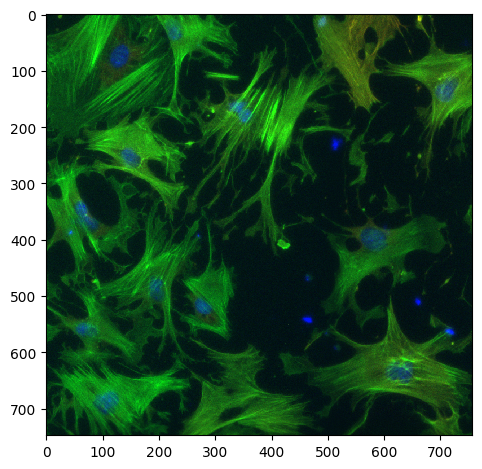

In [6]:
imshow(image)
image.dtype, image.min(), image.max(), image.shape

## Generating a feature stack
Pixel classifiers such as the random forest classifier takes multiple images as input. We typically call these images a feature stack because for every pixel exist now multiple values (features). In the following example we create a feature stack containing three features:
* The original pixel value
* The pixel value after a Gaussian blur
* The pixel value of the Gaussian blurred image processed through a Sobel operator.

Thus, we denoise the image and detect edges. All three images serve the pixel classifier to differentiate positive an negative pixels.

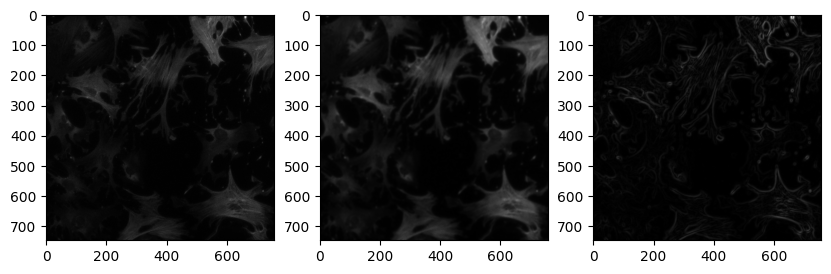

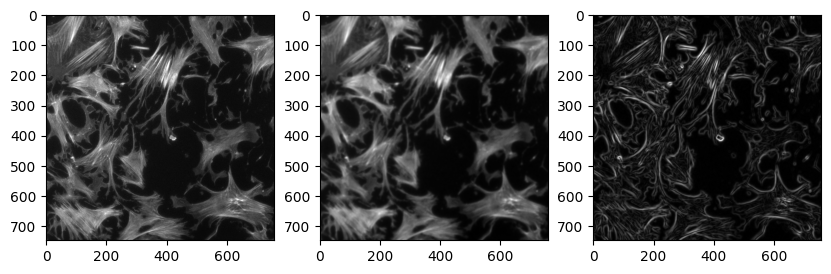

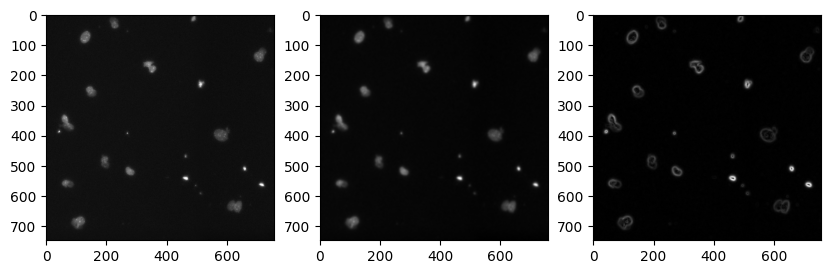

In [13]:
from skimage import filters
import numpy as np

def generate_feature_stack(image):
    # determine features

    # collect features in a stack
    # The ravel() function turns a nD image into a 1-D image.
    # We need to use it because scikit-learn expects values in a 1-D format here. 
    
    feature_stack = []
    for i in range(3):
        blurred = filters.gaussian(image[...,i], sigma=2)
        edges = filters.sobel(blurred)
        feature_stack.append(image[...,i].ravel())
        feature_stack.append(blurred.ravel())
        feature_stack.append(edges.ravel())

    
    #feature_stack = [
        #image.ravel(),
        #blurred.ravel(),
        #edges.ravel()
    #    image.reshape(-1,3),
    #    blurred.reshape(-1,3),
    #    edges.reshape(-1,3)
    #]
    
    # return stack as numpy-array
    return np.asarray(feature_stack)

feature_stack = generate_feature_stack(image)

# show feature images
import matplotlib.pyplot as plt

for i in range(3):
    fig, axes = plt.subplots(1, 3, figsize=(10,10))

    channel_shape = [image.shape[0], image.shape[1]]

    # reshape(image.shape) is the opposite of ravel() here. We just need it for visualization.
    axes[0].imshow(feature_stack[3*i].reshape(channel_shape), cmap=plt.cm.gray)
    axes[1].imshow(feature_stack[3*i+1].reshape(channel_shape), cmap=plt.cm.gray)
    axes[2].imshow(feature_stack[3*i+2].reshape(channel_shape), cmap=plt.cm.gray)

## Formating data
We need to format the input data so that it fits to what scikit learn expects. Scikit-learn asks for an array of shape (n, m) as input data and (n) annotations. n corresponds to number of pixels and m to number of features. In our case m = 3.

In [14]:
def format_data(feature_stack, annotation):
    # reformat the data to match what scikit-learn expects
    # transpose the feature stack
    X = feature_stack.T
    # make the annotation 1-dimensional
    y = annotation.ravel()
    
    # remove all pixels from the feature and annotations which have not been annotated
    mask = y > 0
    X = X[mask]
    y = y[mask]

    return X, y

## Interactive segmentation
We can also use napari to annotate some regions as negative (label = 1) and positive (label = 2).

In [15]:
import napari

# start napari
viewer = napari.Viewer()

# add image
viewer.add_image(image)

# add an empty labels layer and keep it in a variable
labels = viewer.add_labels(np.zeros((image.shape[0], image.shape[1])).astype(int))

# Manual annotation
The user (that might be YOU!) should annotate two regions inside and outside the objects of interest. First, use `Paint mode` to annotate background. Then, increase the `label` by clicking the `+` button an annotate also some objects of interest.

Your annotation should approximately look like this:

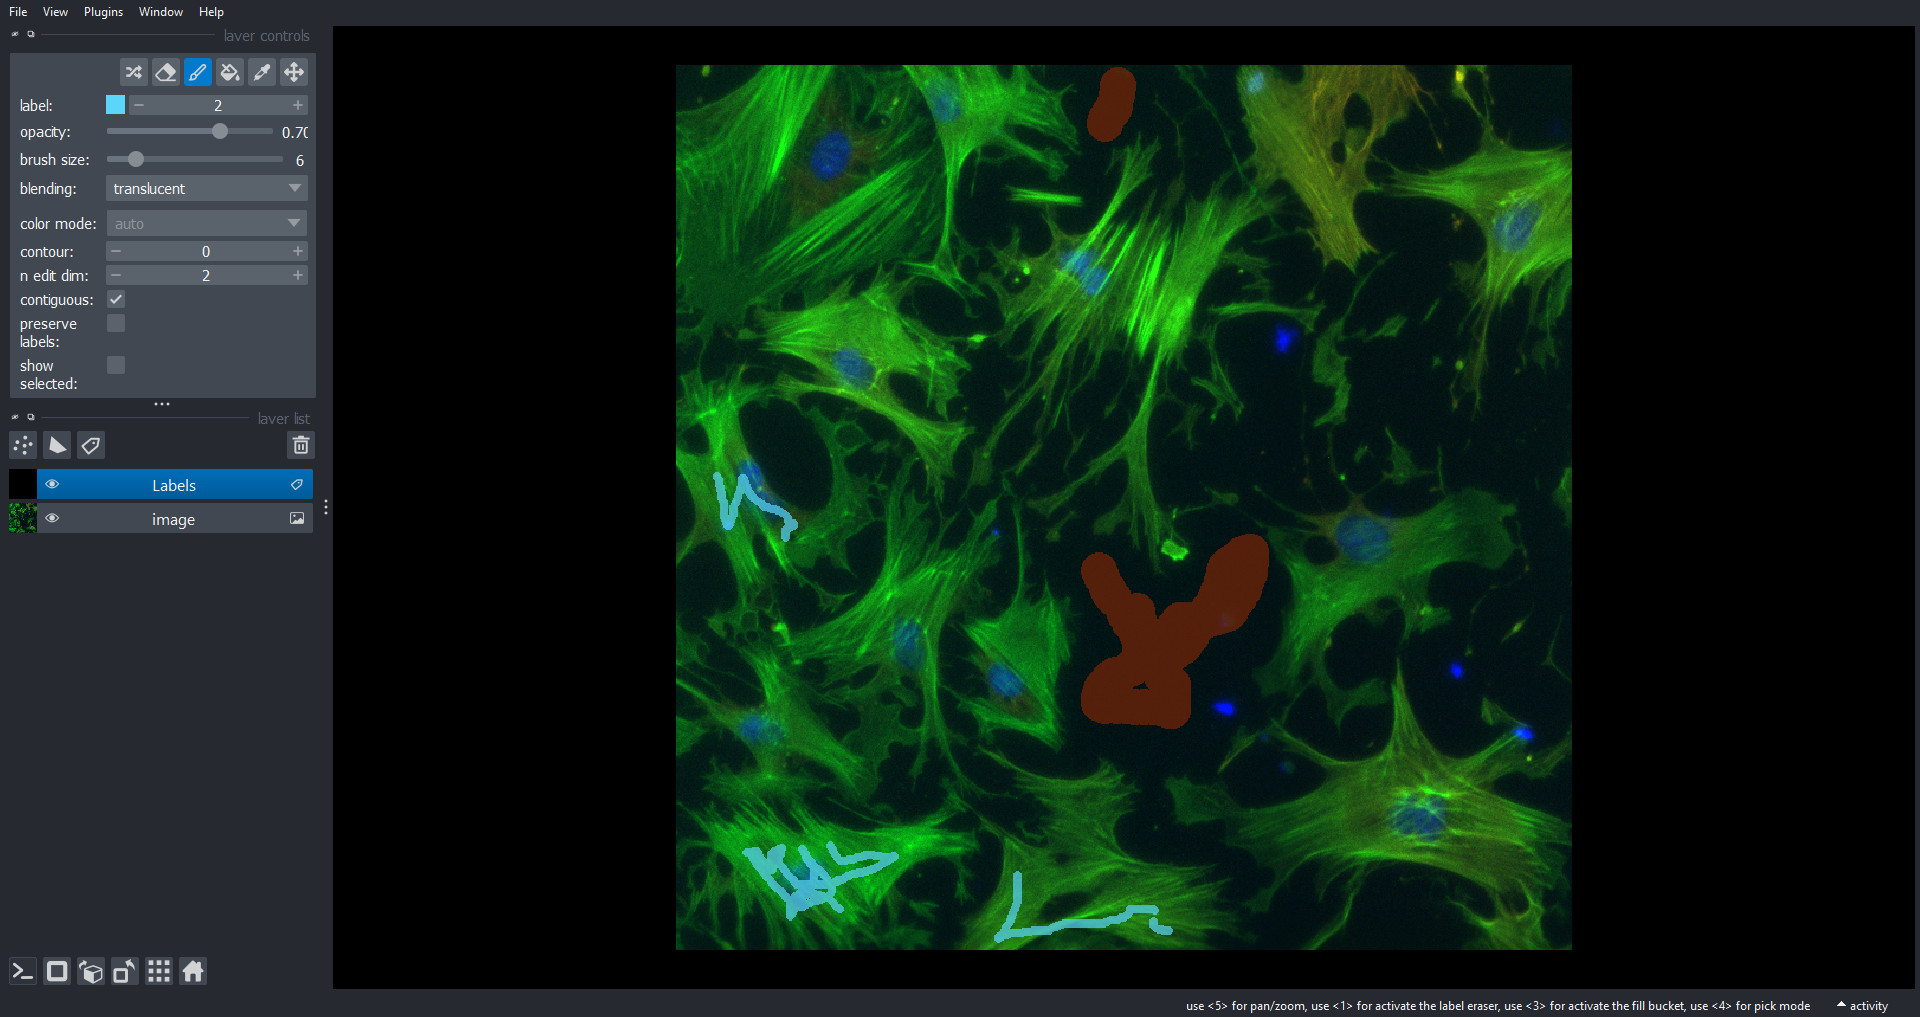

In [16]:
napari.utils.nbscreenshot(viewer)

## Training the random forest classifier
We now train the [random forest classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) by providing the feature stack X and the annotations y. Therefore, we retrieve the annotations from the napari layer:

c:\Users\bnort\miniconda3\envs\pytorch_and_SAM3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


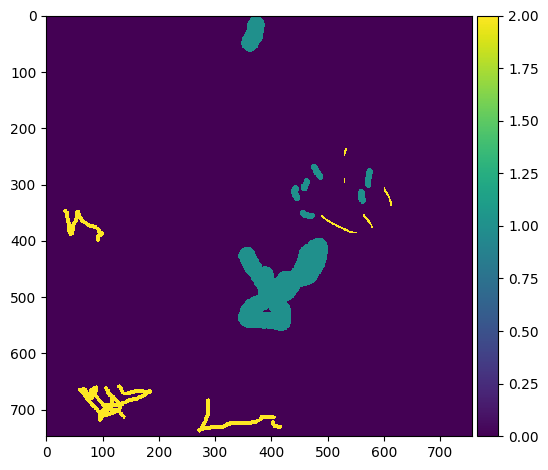

In [22]:
manual_annotations = labels.data

from skimage.io import imshow
imshow(manual_annotations, vmin=0, vmax=2)

In [23]:
# for training, we need to generate features
feature_stack = generate_feature_stack(image)
X, y = format_data(feature_stack, manual_annotations)

# train classifier
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=200,max_depth=10, random_state=0)
classifier.fit(X, y)

RandomForestClassifier(max_depth=10, n_estimators=200, random_state=0)

## Predicting pixel classes
After the classifier has been trained, we can use it to predict pixel classes for whole images. Note in the following code, we provide `feature_stack.T` which are more pixels then X in the commands above, because it also contains the pixels which were not annotated before.

In [24]:

# process the whole image and show result
result_1d = classifier.predict(feature_stack.T) # we subtract 1 to make background = 0
result_2d = result_1d.reshape(manual_annotations.shape)

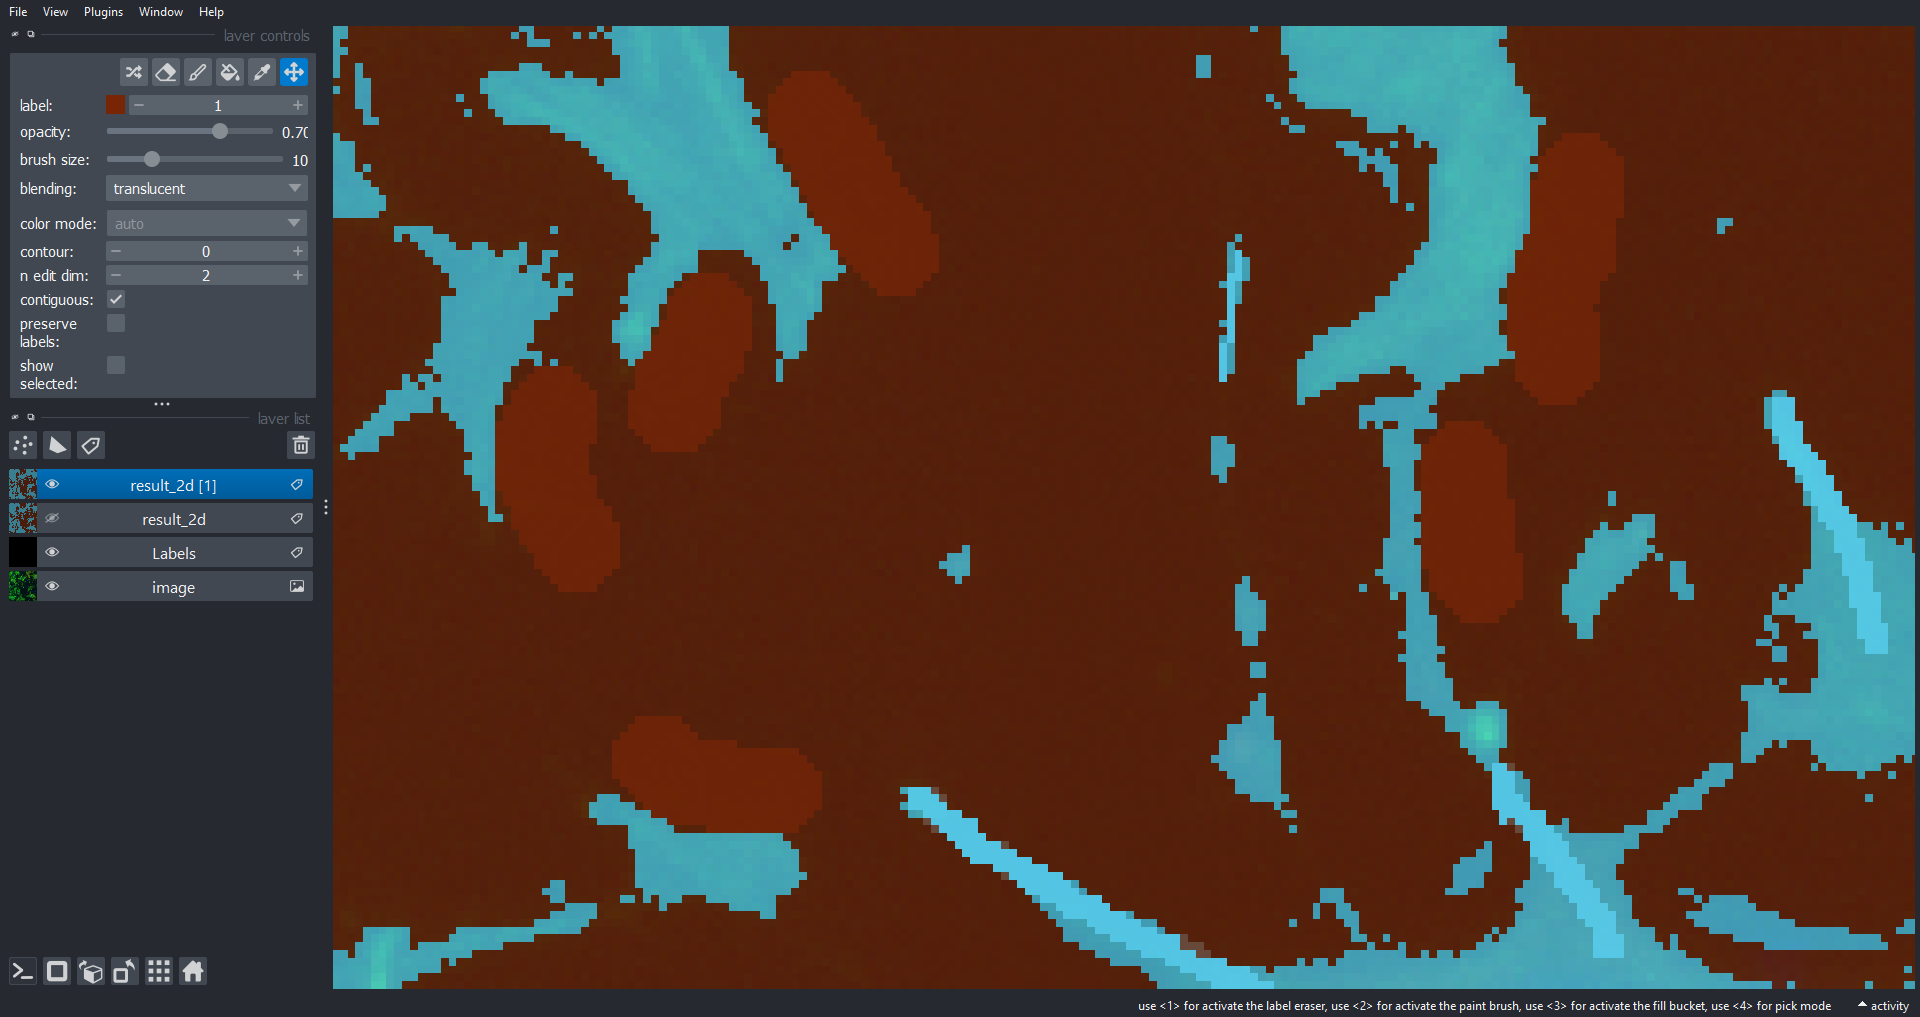

In [25]:
result_layer = viewer.add_labels(result_2d)

napari.utils.nbscreenshot(viewer)